In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.feature import hog

### Load data

In [3]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

def to_image(img_flat):
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img

In [4]:
imgs1= unpickle("/home/maui/MLRF/MLRF_PROJECT/data/external/data_batch_1")
imgs2= unpickle("/home/maui/MLRF/MLRF_PROJECT/data/external/data_batch_2")
imgs3= unpickle("/home/maui/MLRF/MLRF_PROJECT/data/external/data_batch_3")
imgs4= unpickle("/home/maui/MLRF/MLRF_PROJECT/data/external/data_batch_4")
imgs5= unpickle("/home/maui/MLRF/MLRF_PROJECT/data/external/data_batch_5")

imgstest = unpickle("/home/maui/MLRF/MLRF_PROJECT/data/external/test_batch")

data_labels = unpickle('/home/maui/MLRF/MLRF_PROJECT/data/external/batches.meta')


In [5]:
x_train = np.concatenate((imgs1[b'data'], imgs2[b'data'], imgs3[b'data'], imgs4[b'data'], imgs5[b'data']))
x_train = [to_image(x) for x in x_train]
y_train = np.concatenate((imgs1[b'labels'], imgs2[b'labels'], imgs3[b'labels'], imgs4[b'labels'], imgs5[b'labels'])).tolist()

x_test = imgstest[b"data"]
x_test = [to_image(x) for x in x_test]
y_test = imgstest[b"labels"]

print('Train data:', len(x_train))
print('Train labels:', len(y_train))
print('Test data:', len(x_test))
print('Test labels:', len(y_test))

Train data: 50000
Train labels: 50000
Test data: 10000
Test labels: 10000


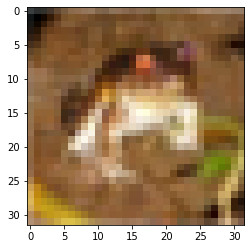

In [6]:
plt.imshow(x_train[0])

### Preprocessing

In [15]:
def extract(data, label):
    descriptors = []
    labels = []
    fe = cv2.SIFT.create()
    for i, img in enumerate(data):
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        desc, _ = hog(img_gray, visualize=True, block_norm='L2-Hys')
        if desc is None:
            desc = np.zeros((0, 128), dtype="uint8")
        descriptors.append(desc)
        labels.append((label[i], len(desc)))
    return descriptors, labels

In [16]:
x_desc, x_label = extract(x_train, y_train)

In [17]:
def normalize(descriptors):
    descriptors  = np.vstack(descriptors)
    descriptors = descriptors.astype(np.float32)
    # Center descriptors
    mean = np.mean(descriptors)
    descriptors = np.apply_along_axis(lambda x: x - mean, axis=0, arr=descriptors)
    # PCA
    train_cov = np.dot(descriptors.T, descriptors)
    eigvals, eigvecs = np.linalg.eig(train_cov)
    perm = eigvals.argsort()
    pca_transform = eigvecs[:, perm[64:128]]
    descriptors = np.dot(descriptors, pca_transform)

    return descriptors, pca_transform, mean

In [18]:
x_desc, pca_transform, mean = normalize(x_desc)
x_desc.shape

(50000, 64)

In [20]:
kmeans = KMeans(n_clusters = 40)
kmeans.fit(x_desc)

KMeans(n_clusters=40)

In [31]:
def histogram(descriptors, train_mean, pca_transform, kmeans):
    image_descriptors = np.zeros((len(descriptors), kmeans.n_clusters), dtype=np.float32)
    
    for ii, desc in enumerate(descriptors):
        print("Indexing %d/%d" % (ii, len(descriptors)), end="\r")
        if desc.shape[0] == 0:
            # let the descriptor be 0 for all values
            # note that this is bad and the element should be dropped from the index
            print("WARNING: zero descriptor for %s" % (ii))
            continue
        
        # convert to float
        desc = desc.astype(np.float32)
        
        # center and apply PCA transform
        desc = np.apply_along_axis(lambda x: x - train_mean, axis=0, arr=desc)
        desc = np.dot(desc, pca_transform)
        
        # get cluster ids
        clabels = kmeans.predict(desc.reshape(1, -1))
        # compute histogram
        descr_hist = np.histogram(clabels, bins=kmeans.n_clusters)[0] / len(clabels)  # FIXME
        
        # update the index
        image_descriptors[ii] = descr_hist
    print("Indexing complete.")
    return image_descriptors

In [29]:
x_desc, x_label = extract(x_train, y_train)

In [ ]:
x_train_desc = histogram(x_desc, mean, pca_transform, kmeans)

In [ ]:
x_desc, x_label = extract(x_test, y_test)
x_test_desc = histogram(x_desc, mean, pca_transform, kmeans)

Indexing complete.


In [ ]:
logReg = LogisticRegression(max_iter=2000)
logReg.fit(x_train_desc, y_train)
acc = logReg.score(x_test_desc, y_test)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 16.52%


In [ ]:
model = SVC(kernel='linear')
model.fit(x_train_desc, y_train)
acc = model.score(x_test_desc, y_test)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 16.30%


In [ ]:
model = RandomForestClassifier()
model.fit(x_train_desc, y_train)
acc = model.score(x_test_desc, y_test)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 16.69%
